# **Data Visualisation**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"
* Answer business requirement 1: Visually differentiate a healthy cherry leaf from one with powdery mildew

## Inputs

* Write here which data or information you need to run the notebook 
* inputs/cherry-leaves_dataset/cherry-leaves/train
* inputs/cherry-leaves_dataset/cherry-leaves/test
* inputs/cherry-leaves_dataset/cherry-leaves/validation

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook
* Image shape embeddings pickle file
* Mean and variability of images per label plot
* Plot to distinguish between infected and uninfected leaves (infected with powedery mildew)
* Generate code that reloves business requirement 1 and can be used to build an image monatge on a streamlit dahsboard.

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here.

# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

Matplotlib is building the font cache; this may take a moment.


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection-in-cherry-leaves'

# Set input directories

Set train, validation amd test paths:

In [5]:
my_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/val'
test_path = my_data_dir + '/test'

---

# Set output directories

In [6]:
version = 'v1'
file_path =f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Existing version already available create a new version')
    pass
else:
    os.makedirs(name=file_path)

Set label names:

In [8]:
labels = os.listdir(train_path)
print('Label for the images is', labels)

Label for the images is ['healthy', 'powdery_mildew']


## Image shape

Compute average image size on train set

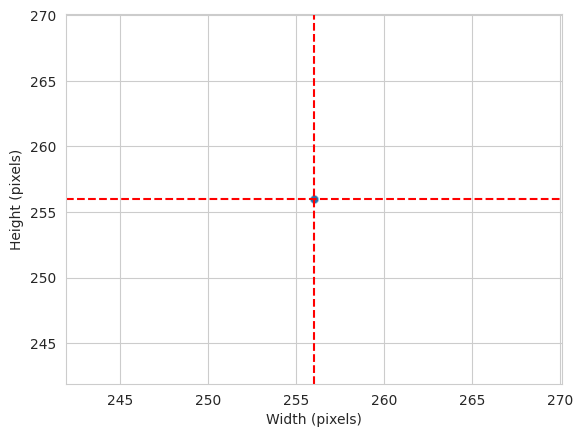

Width average: 256 
Height average: 256


In [9]:
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1) # image height
    dim2.append(d2) # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

From this we can conclude that the images are in the train data set are all the same size, we'll then go ahead and save this along with the standard RGB in a pickle file. 

In [10]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

In [11]:
joblib.dump(value=image_shape,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

## Average variability of images per label

Here we decalre a function to load images into an array using tensorflow

In [12]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), num_imgs_per_label = 20):
    x, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)
    
    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < num_imgs_per_label:
                
                img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resize = image.img_to_array(img) / 255
                else:
                    img_resize = image.img_to_array(img)
                    
                x = np.append(x, img_resize).reshape(-1, new_size[0], new_size[1], img_resize.shape[2])
                y = np.append(y, label)
                counter += 1
    
    return x, y

2023-06-12 18:07:21.545689: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 18:08:45.795360: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 18:08:46.062549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 18:10:03.141909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load the image shanpe and labels into the array.

In [13]:
x, y = load_image_as_array(my_data_dir=train_path, new_size=image_shape, num_imgs_per_label=30)
print(x.shape, y.shape)

(60, 256, 256, 3) (60,)


Plot and save mean and variability of the images per label using the definitions assigned above.

In [14]:
def plot_mean_var_per_label(x, y, figsize=(12,5), save_image=False):
    
    # loop through labels
    for display_label in np.unique(y):
        sns.set_style("white")

        # subset an array for the given label
        y = y.reshape(-1, 1, 1)
        bool_mask = np.any(y==display_label, axis=1).reshape(-1)
        arr = x[bool_mask] 
        
        # calculate mean and standard deviation
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label: {display_label} ====")
        print(f"==== Image Shape: {avg_img.shape} ====")
        
        # create fig displaying mean and variance of images
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for {display_label}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variance image for {display_label}")
        axes[1].imshow(std_img, cmap='gray')
        
        # save the image
        if save_image:
            plt.savefig(f"{file_path}ag_var_{display_label}.png", bbox_inches="tight", dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

plot_mean_var_per_label(x=x, y=y, figsize=(12, 5), save_image=True)

## Difference between infected and healthy leaf images

In [16]:
def subset_img_label(x, y, display_label):
    y = y.reshape(-1, 1, 1)
    bool_mask = np.any(y==display_label, axis=1).reshape(-1)
    df = x[bool_mask]
    return df

def diff_bet_avg_image_labels_data_as_array(x, y, label_1, label_2, figsize=(20,5), save_image=False):
    sns.set_style("white")
    
    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either {label_1} or {label_2} are not in {np.unique(y)}")
        return
        
    # calculate the mean from labels
    # label 1
    images_label = subset_img_label(x, y, label_1)
    label1_avg = np.mean(images_label, axis=0)
    
    # label 2
    images_label = subset_img_label(x, y, label_2)
    label2_avg = np.mean(images_label, axis=0)
    
    # calculate and plot difference between avg label1 and avg label2
    diff_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average: {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average: {label_2}')
    axes[2].imshow(diff_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


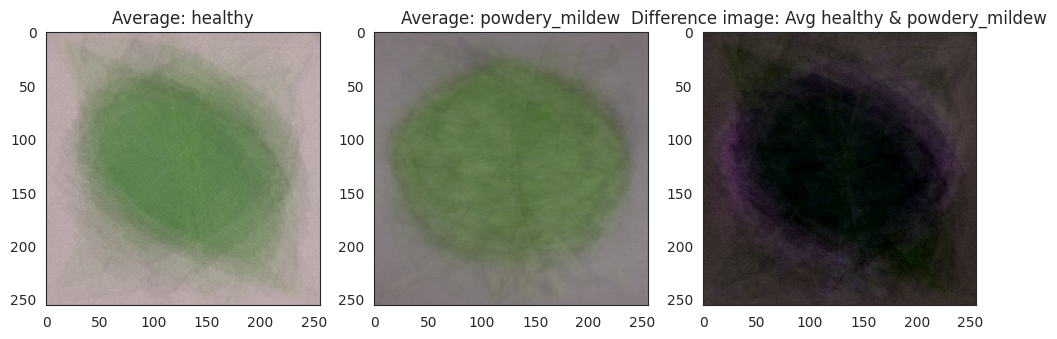

In [17]:
diff_bet_avg_image_labels_data_as_array(x=x, y=y, label_1='healthy', label_2='powdery_mildew',
                                       figsize=(12,10),
                                       save_image=True)

## Image Montage

In [18]:
import itertools
import random
sns.set_style("white")

def image_montage(dir_path, display_label, nrows, ncols, figsize=(15,10)):

    labels = os.listdir(dir_path)
    
    if display_label in labels:
        
        images_list = os.listdir(dir_path+'/'+display_label)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else: 
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return
        
        list_rows = range(0,nrows)
        list_cols = range(0,ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))
        
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for i in range(0, nrows*ncols):
            img = imread(dir_path + '/' + display_label +'/' + img_idx[i])
            img_shape = img.shape
            axes[plot_idx[i][0], plot_idx[i][1]].imshow(img)
            axes[plot_idx[i][0], plot_idx[i][1]].set_title(f"Witdth {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[i][0], plot_idx[i][1]].set_xticks([])
            axes[plot_idx[i][0], plot_idx[i][1]].set_yticks([])
        plt.tight_layout()
        plt.show()
    else:
        print("The selected label does not exists")
        print(f"The existing options are: {labels}")

healthy


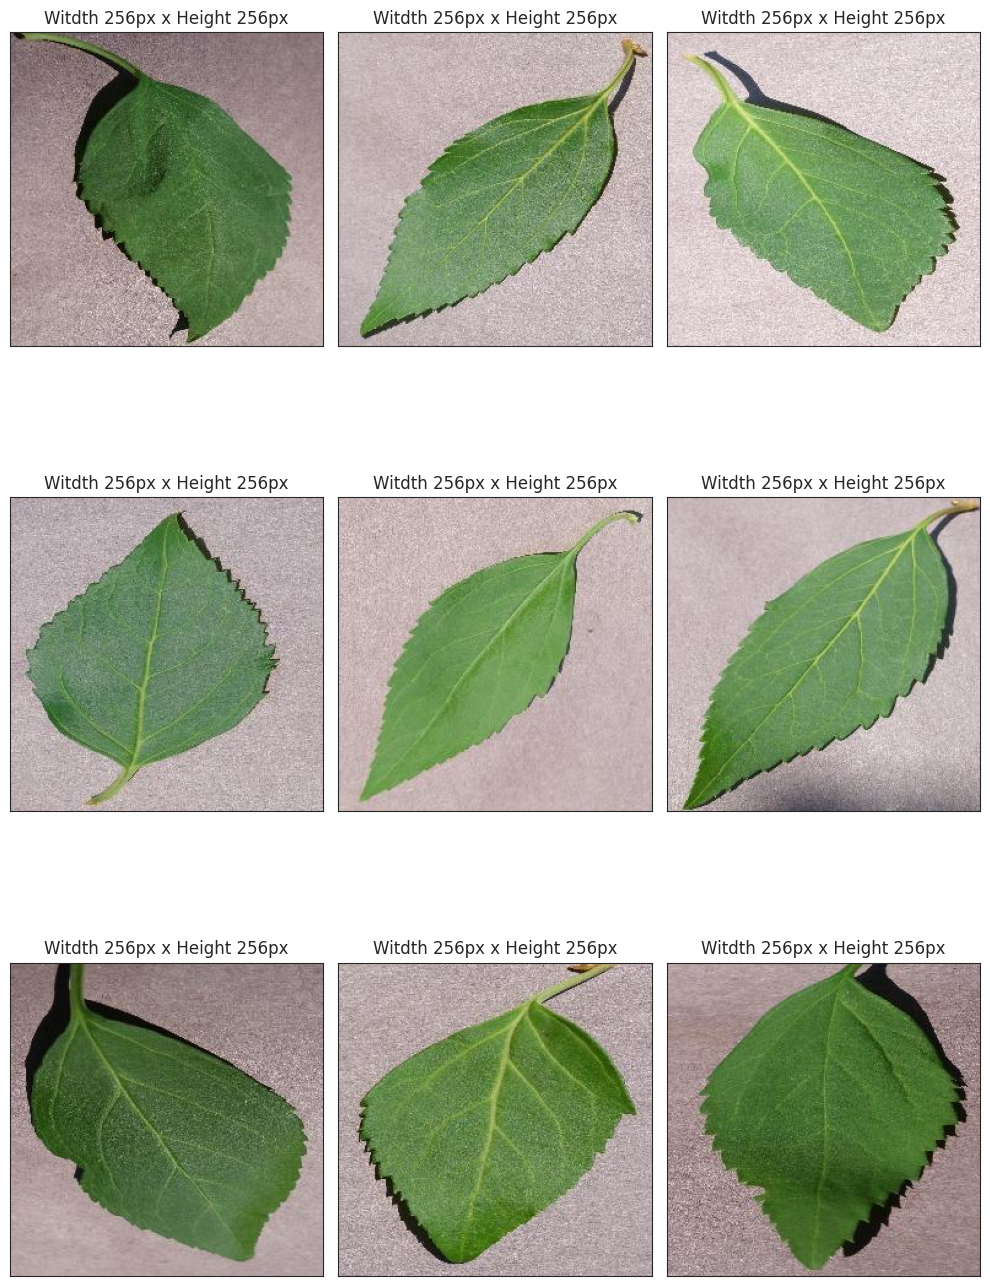



powdery_mildew


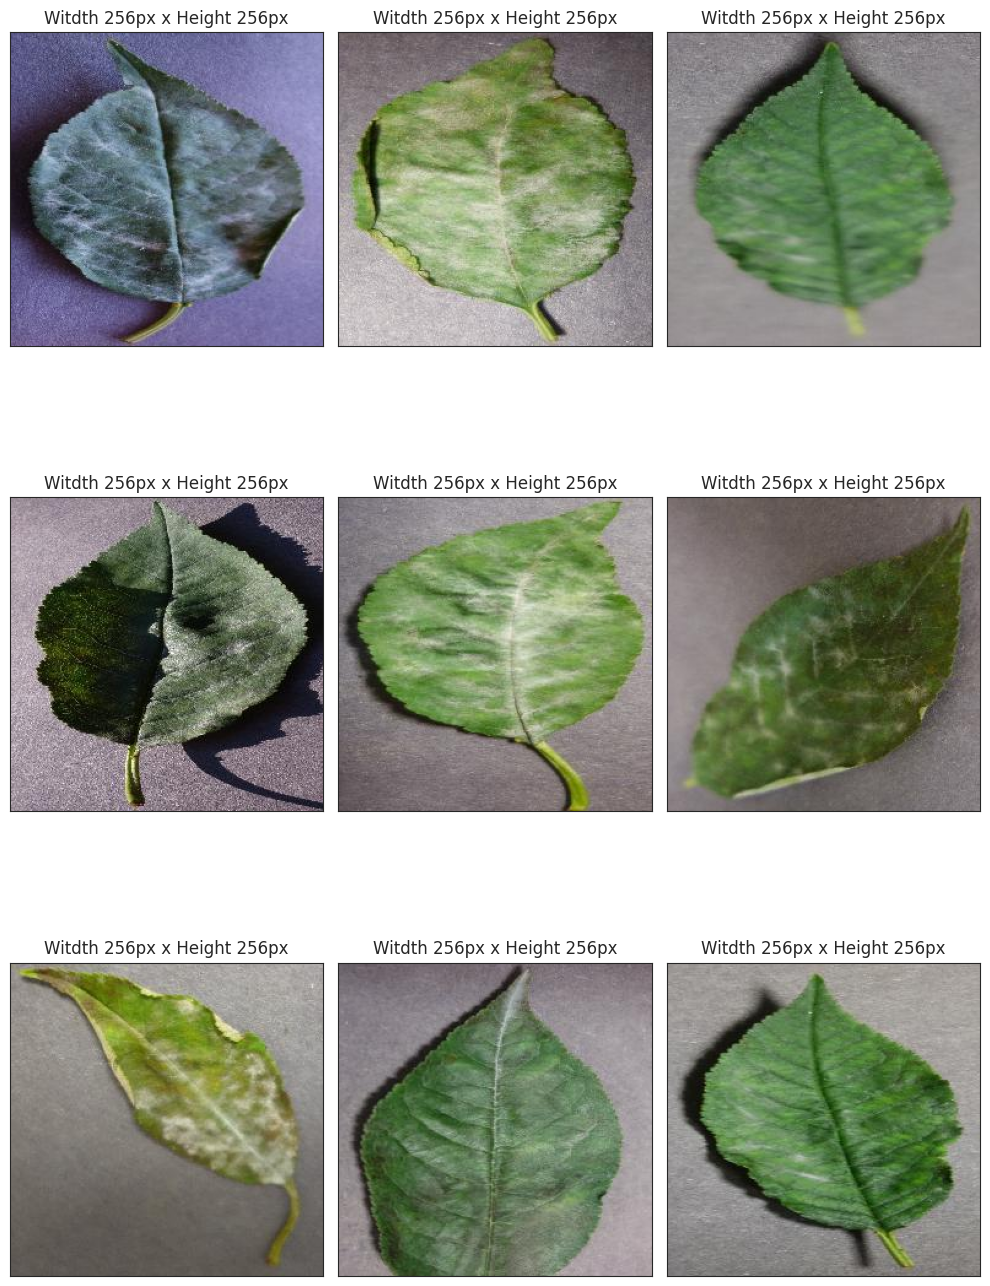

In [19]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  display_label=label,
                  nrows=3, ncols=3,
                  figsize=(10,15)
                  )
    print("\n")

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
